# Importing Libaries and Checking our dataset
This dataset contains information on Spotify tracks spanning 125 different genres. Each track is described by various audio features and metadata.

We will use this dataset for our random forest for predicting hit songs featues

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [28]:

df = pd.read_csv("/content/dataset.csv")

df['duration'] = (df['duration_ms'] / 60000).round(2)

df.drop(['duration_ms'], axis=1, inplace=True)



numeric_values=df[['popularity', 'danceability', 'energy', 'loudness', 'valence', 'tempo','duration','liveness','acousticness','speechiness','duration','mode']]
print("\nMedian Values for Numeric Columns:")
print(numeric_values.median())
print(numeric_values.mean())


Median Values for Numeric Columns:
popularity       35.0000
danceability      0.5800
energy            0.6850
loudness         -7.0040
valence           0.4640
tempo           122.0170
duration          3.5500
liveness          0.1320
acousticness      0.1690
speechiness       0.0489
duration          3.5500
mode              1.0000
dtype: float64
popularity       33.238535
danceability      0.566800
energy            0.641383
loudness         -8.258960
valence           0.474068
tempo           122.147837
duration          3.800467
liveness          0.213553
acousticness      0.314910
speechiness       0.084652
duration          3.800467
mode              0.637553
dtype: float64


# Creating Visuals for understanding our dataset
With this visuals we can look for the relations in this dataset understanding this part could help us choose correct parameters

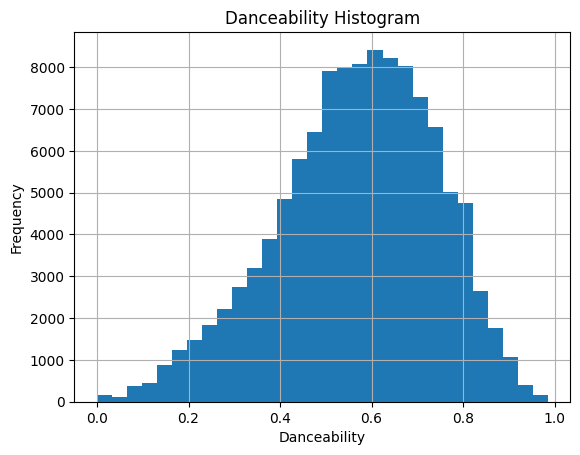

In [5]:
df['danceability'].hist(bins=30)
plt.title("Danceability Histogram")
plt.xlabel("Danceability")
plt.ylabel("Frequency")
plt.show()

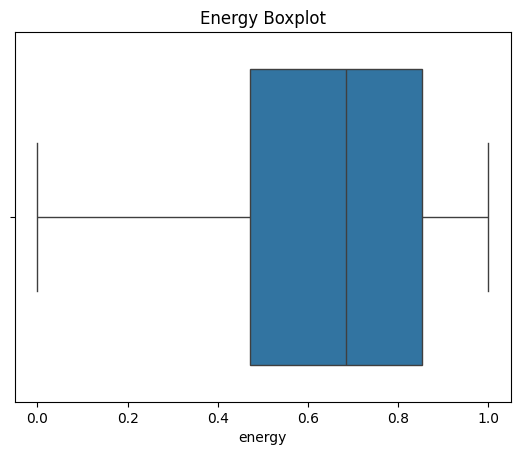

In [6]:
sns.boxplot(x=df['energy'])
plt.title("Energy Boxplot")
plt.show()

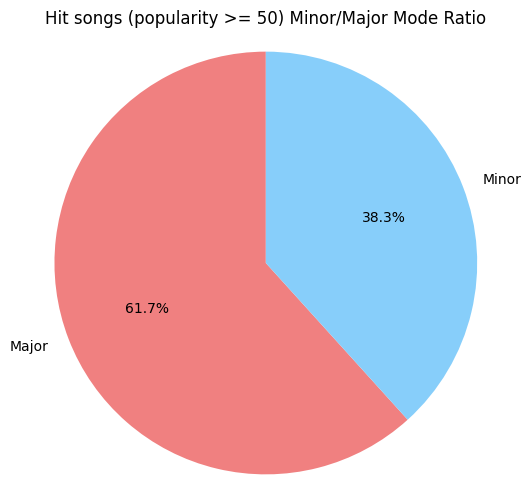

In [16]:

popular_songs = df[df['popularity'] >= 50]


mode_ratio = popular_songs['mode'].value_counts(normalize=True)

labels = ['Major', 'Minor']

plt.figure(figsize=(6, 6))
plt.pie(mode_ratio, labels=labels, autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'], startangle=90)
plt.title("Hit songs (popularity >= 50) Minor/Major Mode Ratio")
plt.axis('equal')
plt.show()

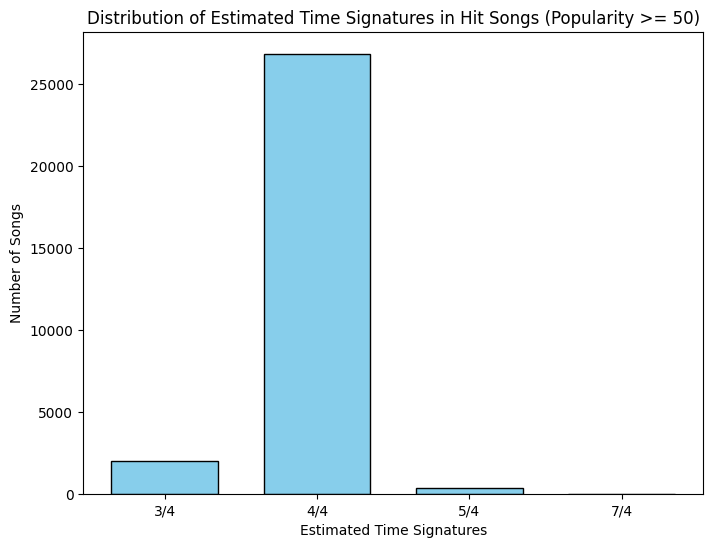

In [53]:
time_signatures = popular_songs['time_signature']
hist_data, bin_edges = np.histogram(time_signatures, bins=np.arange(3, 8))


plt.figure(figsize=(8, 6))
plt.bar(bin_edges[:-1], hist_data, color='skyblue', edgecolor='black', width=0.7, align='center')


time_signature_labels = ['3/4', '4/4', '5/4', '7/4']
plt.xticks(bin_edges[:-1], time_signature_labels)

plt.xlabel('Estimated Time Signatures')
plt.ylabel('Number of Songs')
plt.title('Distribution of Estimated Time Signatures in Hit Songs (Popularity >= 50)')
plt.show()

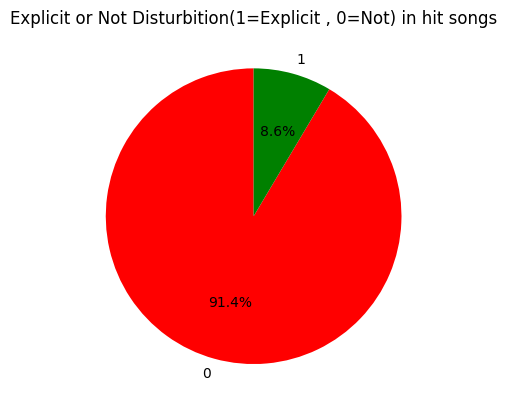

In [58]:
df['explicit'] = df['explicit'].astype(int)
explicit_songs = df['explicit'].value_counts()

explicit_songs.plot(kind='pie', autopct='%1.1f%%', colors=['red', 'green'], startangle=90)
plt.title("Explicit or Not Disturbition(1=Explicit , 0=Not) in hit songs")
plt.ylabel("")
plt.show()

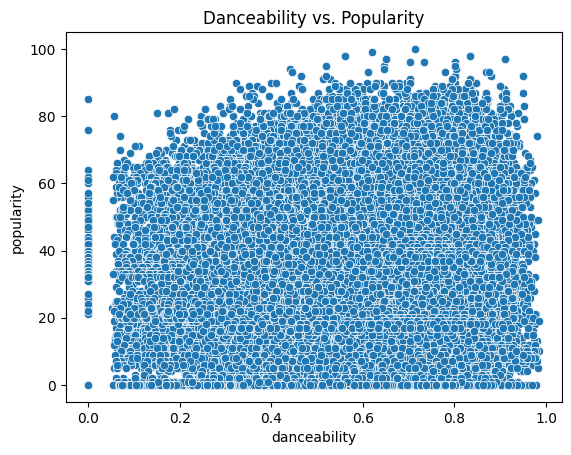

In [17]:
sns.scatterplot(x=df['danceability'], y=df['popularity'])
plt.title("Danceability vs. Popularity")
plt.show()

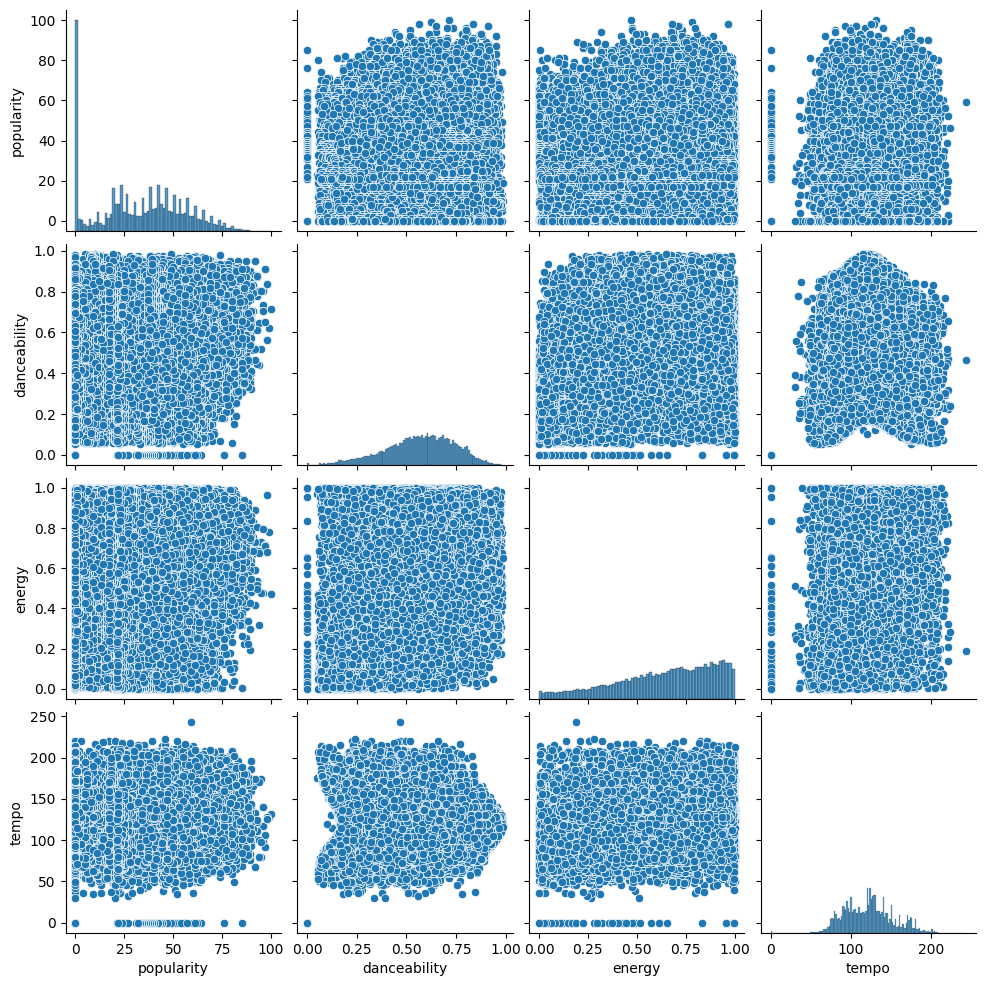

In [64]:
sns.pairplot(df[['popularity', 'danceability', 'energy', 'tempo']])
plt.show()


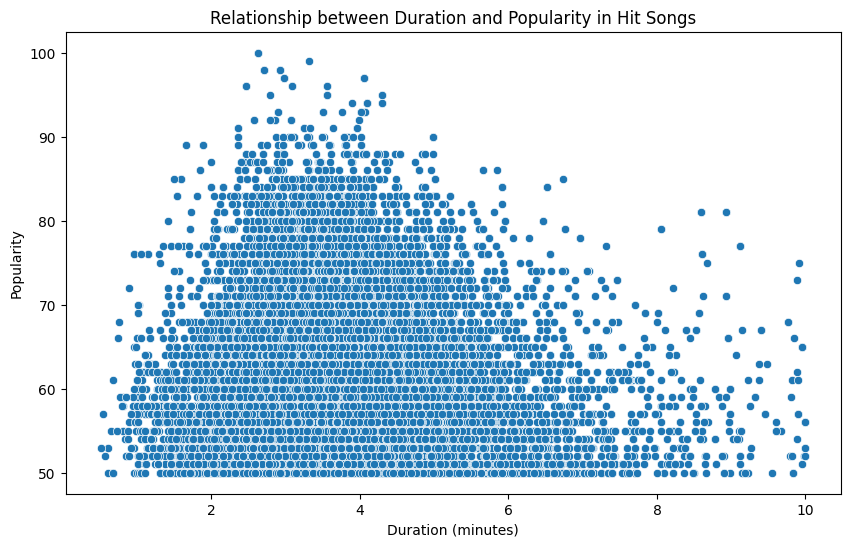

In [68]:
filtered_data=popular_songs[popular_songs['duration'] <= 10]
plt.figure(figsize=(10, 6))
sns.scatterplot(x='duration', y='popularity', data=filtered_data)
plt.title('Relationship between Duration and Popularity in Hit Songs')
plt.xlabel('Duration (minutes)')
plt.ylabel('Popularity')
plt.show()

<ipython-input-63-103743de3148>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['key'], y=df['popularity'], palette="coolwarm")


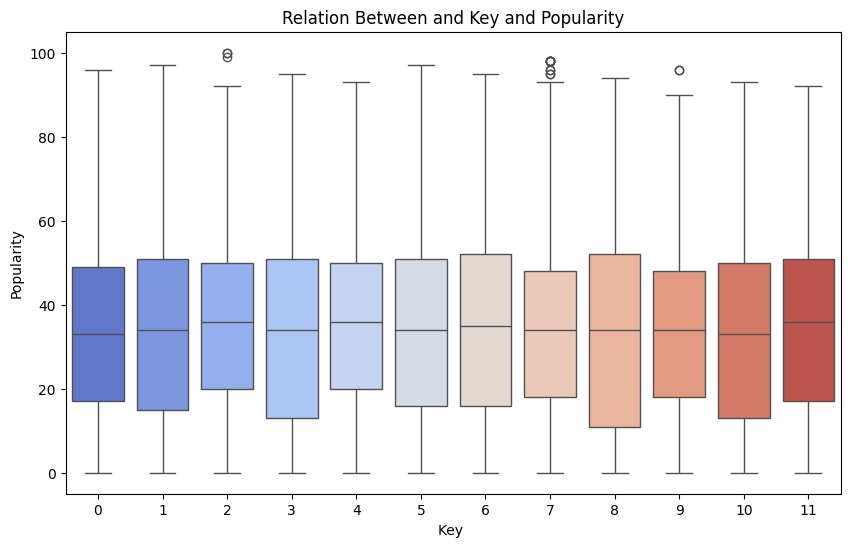

In [63]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df['key'], y=df['popularity'], palette="coolwarm")
plt.xlabel("Key ")
plt.ylabel("Popularity")
plt.title("Relation Between and Key and Popularity")
plt.show()

In [11]:
corr_matrix = df[['popularity', 'danceability', 'energy', 'loudness', 'valence', 'tempo','duration','liveness','acousticness','speechiness']].corr()
print(corr_matrix)

              popularity  danceability    energy  loudness   valence  \
popularity      1.000000      0.035448  0.001056  0.050423 -0.040534   
danceability    0.035448      1.000000  0.134325  0.259077  0.477341   
energy          0.001056      0.134325  1.000000  0.761690  0.258934   
loudness        0.050423      0.259077  0.761690  1.000000  0.279848   
valence        -0.040534      0.477341  0.258934  0.279848  1.000000   
tempo           0.013205     -0.050450  0.247851  0.212446  0.078273   
duration       -0.007090     -0.073432  0.058514 -0.003477 -0.154477   
liveness       -0.005387     -0.131617  0.184796  0.076899  0.019086   
acousticness   -0.025472     -0.171533 -0.733906 -0.589803 -0.107070   
speechiness    -0.044927      0.108626  0.142509  0.060826  0.036635   
mode           -0.013931     -0.069219 -0.078362 -0.041764  0.021953   

                 tempo  duration  liveness  acousticness  speechiness  \
popularity    0.013205 -0.007090 -0.005387     -0.025472    -0

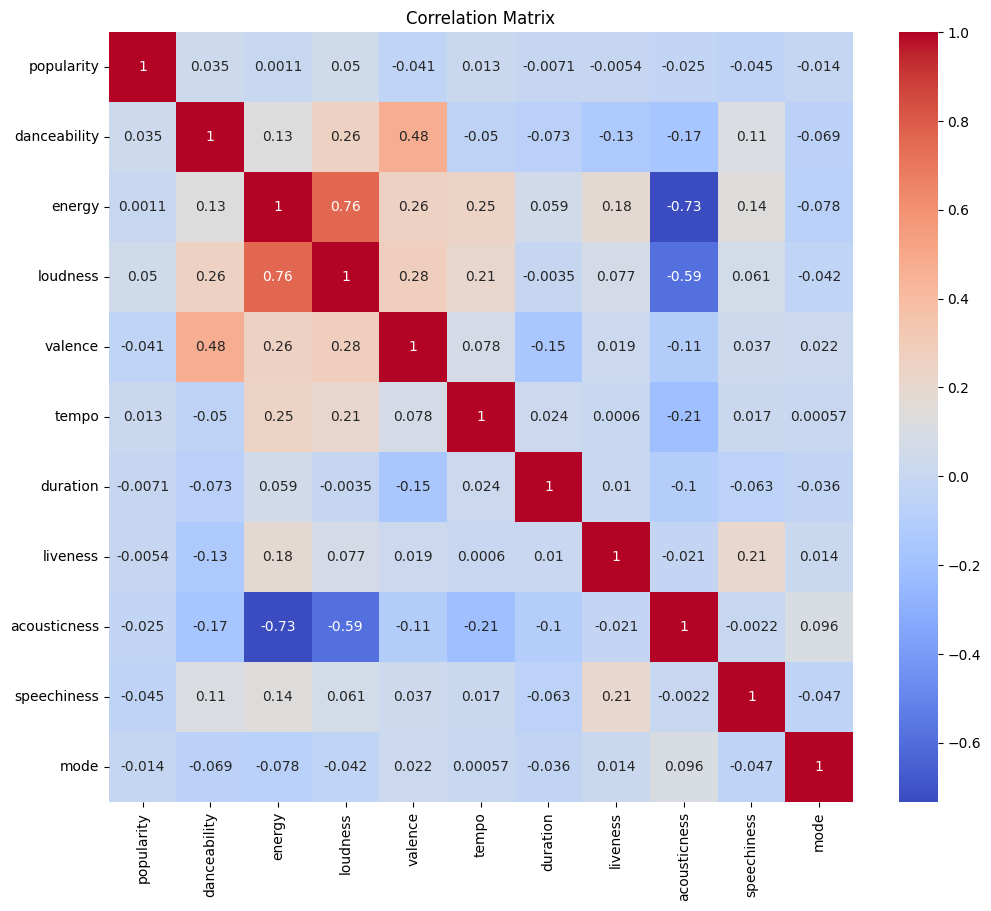

In [13]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


# Starting Our Training
We will first use binary classification and get our features and start our model

After that we will show our models accuracy classification report and confusion matrix
also we will show the each features importance rate

In [73]:
df['hit'] = (df['popularity'] > 50).astype(int)

In [72]:
features = ['danceability', 'energy', 'valence', 'tempo', 'acousticness',
            'speechiness', 'loudness', 'instrumentalness', 'key', 'mode', 'explicit']

X = df[features]
y = df['hit']

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15, class_weight="balanced")
rf_model.fit(X_train_scaled, y_train)

y_pred = rf_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))



Model Accuracy: 0.7087
              precision    recall  f1-score   support

           0       0.87      0.72      0.79     17246
           1       0.44      0.68      0.53      5554

    accuracy                           0.71     22800
   macro avg       0.66      0.70      0.66     22800
weighted avg       0.77      0.71      0.73     22800



<ipython-input-86-06dbc570212d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="viridis")


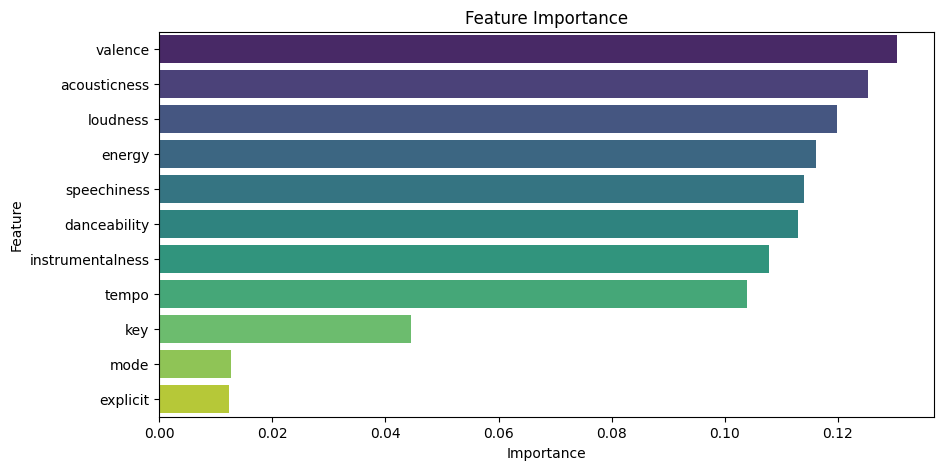

In [86]:
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="viridis")
plt.title("Feature Importance")
plt.show()

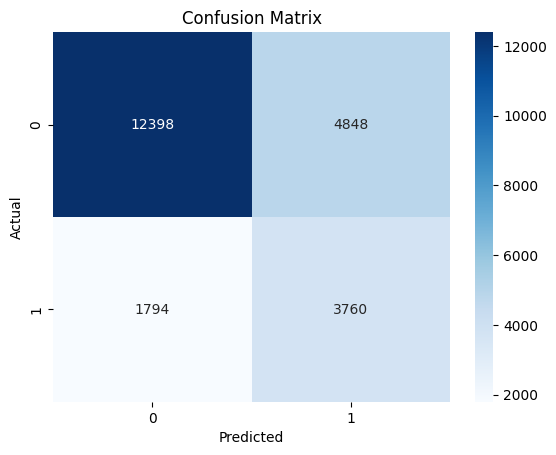

In [87]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Hypermeter Optimization
Will use GridSearch for optimizing our parameters and after that we will increase our accuracy and other parameters

What grid search will do is with parameters we given it tries every combination and gives us the best parameters with most accuracy



In [84]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}
